# 初期設定

In [325]:
from typing import *
import os
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
# import numba

# 機械学習ライブラリ
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, f1_score, r2_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

INPUT_DIR = os.path.join('..', 'features')

## データの読み込み

In [327]:
input_data_path = os.path.join(INPUT_DIR, 'bybit.pkl.bz2')

ftx_data_path = os.path.join(INPUT_DIR, 'ftx.pkl.bz2')
bitmex_data_path = os.path.join(INPUT_DIR, 'bitmex.pkl.bz2')
df_ftx = pd.read_pickle(ftx_data_path)
df_bitmex = pd.read_pickle(bitmex_data_path)
df_temp = pd.merge(df_ftx, df_bitmex, on='timestamp')

df_features = pd.read_pickle(input_data_path)
df_features = pd.merge(df_features, df_temp, on='timestamp')
df_features

,timestamp,open,high,low,close,volume,buy_size_1,buy_size_2,buy_price_1,buy_price_2,sell_size_1,sell_size_2,sell_price_1,sell_price_2,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,trade_signal_macd,trade_signal_bb,ask_bit_spread,size_ratio,open_x,high_x,low_x,close_x,volume_x,buy_size_1_x,buy_size_2_x,buy_price_1_x,buy_price_2_x,sell_size_1_x,sell_size_2_x,sell_price_1_x,sell_price_2_x,ask_bit_spread_x,size_ratio_x,open_y,high_y,low_y,close_y,volume_y,buy_size_1_y,buy_size_2_y,buy_price_1_y,buy_price_2_y,sell_size_1_y,sell_size_2_y,sell_price_1_y,sell_price_2_y,ask_bit_spread_y,size_ratio_y
0,2021-10-04 02:05:30.000768,48016.0,48016.5,48016.0,48016.5,3867.0,5847362.0,166623.0,48016.0,48015.5,883330.0,354584.0,48016.5,48017.0,0.439900,-0.05,-0.539900,1.932607,6.905940,12.551613,2.228047,11.350000,0.00,11.350000,0.778371,-2.766481,10.604167,5.470430,69.256062,73.823764,-9.326923,100.000000,100.000000,0.000000,77.777778,62.958704,-4.483733,-4.486531,0.002798,68.456374,57.299095,8.137139,0.5,13.024360,1.849611,23.764333,3.333333e+01,33.333333,100.000000,3.333333e+01,100.000000,8.565098e+01,-0.000039,43.580705,-0.000000,-1.975441e+06,3.828658e+05,-749785.0,1.014846,0.002114,0.5,28.169972,3.406922,-0.135746,-0.435487,0.059427,0.747878,0,0.000000,0.936700,-0.185714,0.881404,-0.385714,0.015385,0.244950,0,1,0.5,0.151065,48056.0,48057.0,48056.0,48057.0,0.7819,1.6196,1.0407,48058.0,48057.0,8.0381,0.3000,48059.0,48060.0,1.0,4.963016,48031.5,48031.5,48031.5,48031.5,6800,91200,42900,48031.0,48028,203900,35500,48031.5,48036,0.5,2.235746
1,2021-10-04 02:05:35.000425,48016.5,48016.5,48016.0,48016.0,21480.0,6003323.0,407505.0,48016.0,48015.5,316926.0,283779.0,48016.5,48017.0,0.439900,-0.05,-0.539900,1.359905,6.444266,11.590753,1.483307,10.533333,0.00,10.533333,0.560551,-3.139881,9.179167,4.722043,68.806251,73.201189,-8.384615,100.000000,100.000000,0.000000,-21.212121,62.958704,-4.301901,-4.449605,0.147704,76.659651,55.205870,7.555914,-0.5,12.548560,1.717496,22.783905,3.333333e+01,33.333333,0.000000,3.333333e+01,69.100967,8.062598e+01,-0.000084,41.805813,-100.000000,-1.996921e+06,2.994462e+05,-771265.0,0.978071,0.002037,0.5,27.154367,12.124488,-0.196752,-0.254681,0.210036,0.839852,0,0.000000,0.936064,0.228571,0.125925,0.200000,0.002198,0.244950,0,1,0.5,0.052792,48057.0,48058.0,48057.0,48058.0,0.0590,3.0175,1.0407,48058.0,48057.0,0.0230,3.7368,48059.0,48061.0,1.0,0.007622,48031.5,48031.5,48031.5,48031.5,6400,137200,100,48031.0,48026,114800,5400,48031.5,48032,0.5,0.836735
2,2021-10-04 02:05:40.001556,48016.0,48016.5,48016.0,48016.0,110603.0,6071868.0,464686.0,48016.0,48015.5,321426.0,335782.0,48016.5,48017.0,0.250000,-0.15,-0.550000,0.852016,6.012378,10.652097,0.927427,9.700000,0.00,9.700000,0.388312,-3.428559,7.856250,4.026344,68.388569,72.623083,-7.442308,100.000000,100.000000,0.000000,-31.111111,62.958704,-4.110415,-4.381767,0.271352,76.659651,53.116190,7.016206,-0.5,12.073565,1.594817,22.783905,3.333333e+01,33.333333,0.000000,3.333333e+01,69.100967,7.940064e+01,-0.000126,32.343847,-100.000000,-2.107524e+06,2.029058e+05,-771265.0,0.943923,0.001966,0.5,26.300961,18.017816,-0.164891,0.275242,0.309313,0.891148,0,0.000000,0.934833,0.142857,-0.629599,0.285714,-0.010989,0.200000,0,1,0.5,0.052937,48058.0,48061.0,48058.0,48061.0,1.9100,11.2987,1.8668,48061.0,48060.0,0.6385,0.1381,48062.0,48063.0,1.0,0.056511,48031.5,48031.5,48031.5,48031.5,4200,217100,100,48031.0,48026,114800,5400,48031.5,48032,0.5,0.528789
3,2021-10-04 02:05:45.001539,4

## 使用する特徴量

In [347]:
df = df_features.copy().reset_index()

In [348]:
# y作成
# 実際にトレードで得られるリターンをyとする
# 参考: https://note.com/btcml/n/n9f730e59848c

pips = 0.5
fee = -0.00025
# fee = 0.00075
# fee = -0.00000

# @numba.njit
def cal_buy_force_entry_price(entry_price, low):
    """買うと決めてから約定するまで指値で追いかけた場合に、実際に約定する価格
    entry_price: numpy array。買い指値。i番目の足の最後で価格entry_price[i]で指値を出し、i + 1番目の足の最後でキャンセルする想定。
    lo: numpy array。低値
    戻り値: y[i]は、i番目の足の最後から執行を始めた場合に、実際に約定する価格
    """
    buy_feps = np.zeros(entry_price.size) 
    buy_horizons = np.zeros(entry_price.size)
    buy_feps[:] = np.nan
    for now in range(entry_price.size):
        num_horizon = 1
        for future in range(now + 1, entry_price.size):
            if round(low[future] / pips) < round(entry_price[future - 1] / pips):
            # if low[future] < entry_price[future - 1]:
                buy_feps[now] = entry_price[future - 1]
                buy_horizons[now] = num_horizon
                break
            num_horizon += 1
            
    return buy_feps, buy_horizons

# @numba.njit
def cal_sell_force_entry_price(entry_price, high):
    sell_feps = np.zeros(entry_price.size) 
    sell_horizons = np.zeros(entry_price.size)
    sell_feps[:] = np.nan
    for now in range(entry_price.size):
        num_horizon = 1
        for future in range(now + 1, entry_price.size):
            if round(high[future] / pips) > round(entry_price[future - 1] / pips):
            # if high[future] > entry_price[future - 1]:
                sell_feps[now] = entry_price[future - 1]
                sell_horizons[now] = num_horizon
                break
            num_horizon += 1

    return sell_feps, sell_horizons


df['buy_fep'], _ = cal_buy_force_entry_price(
    entry_price=df['buy_price_1'].values,
    low=df['low'].values)

df['sell_fep'], _ = cal_sell_force_entry_price(
    entry_price=df['sell_price_1'].values,
    high=df['high'].values)



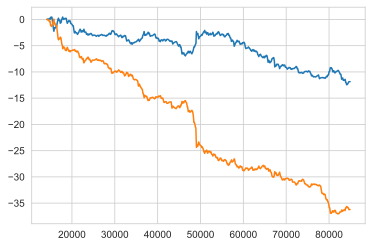

25096
48.55285693940561
28327
-60.41439351815686


In [354]:
horizon = 100
limit = 60

def cal_profit(exit, entry):
    return (exit / entry - 1) - 2 * fee

def make_buy_y_label(sell_fep, buy_price, low):
    y_buy = np.zeros(sell_fep.size)
    for i in range(sell_fep.size-limit-horizon):
        for j in range(i+1, i+limit):
            # if round(buy_price[i] / pips) > round(low[j] / pips):
            if buy_price[i] > low[j]:
                y_buy[i] = (sell_fep[j+horizon] / buy_price[i] - 1) - 2 * fee
                # temp = np.array([cal_profit(sell_fep[j+k], buy_price[i]) for k in range(horizon)])
                # y_buy[i] = np.argmax(temp)
                break
    return y_buy
    
def make_sell_y_label(buy_fep, sell_price, high):
    y_sell = np.zeros(buy_fep.size) 
    for i in range(buy_fep.size-limit-horizon):
        for j in range(i+1, i+limit):
            # if round(sell_price[i] / pips) < round(high[j] /pips):
            if sell_price[i] < high[j]:
                y_sell[i] = -(buy_fep[j+horizon] / sell_price[i] - 1) - 2 * fee
                break
    return y_sell
    

df['y_buy'] = make_buy_y_label(sell_fep=df['sell_fep'].values, buy_price=df['buy_price_1'].values, low=df['low'].values)
df['y_sell'] = make_sell_y_label(buy_fep=df['buy_fep'].values, sell_price=df['sell_price_1'].values, high=df['high'].values)

df['y_buy'].cumsum().plot()
df['y_sell'].cumsum().plot()
plt.show()


print(len(df[df['y_buy'] > 0]))
print(df[df['y_buy'] > 0]['y_buy'].sum())

print(len(df[df['y_buy'] < 0]))
print(df[df['y_buy'] < 0]['y_buy'].sum())

# df['y_buy'].value_counts().plot(kind="bar")

In [356]:
# df[df['y_buy'] > 0.001][['size_ratio', 'y_buy']][:100]


print(len(df[(df['size_ratio'] > 1)]))
print(len(df[(df['size_ratio'] < 1)]))

print(len(df[(df['y_buy'] > 0.00) & (df['size_ratio'] > 1)]))
print(len(df[(df['y_buy'] < 0.00) & (df['size_ratio'] > 1)]))
# print(len(df[(df['y_buy'] > 0.00) & (df['size_ratio'] < 1)]))

33574
37130
13389
15066


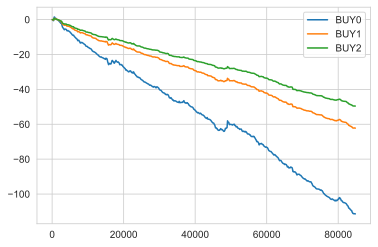

In [316]:
df[df['size_ratio'] > 0]['y_buy'].cumsum().plot(label='BUY0')
df[df['size_ratio'] > 1]['y_buy'].cumsum().plot(label='BUY1')
df[df['size_ratio'] > 2]['y_buy'].cumsum().plot(label='BUY2')
plt.legend()
plt.show()

# 機械学習モデル作成

In [357]:
features = sorted([
#     'ADX',
#     'ADXR',
#     'APO',
#     'AROON_aroondown',
#     'AROON_aroonup',
#     'AROONOSC',
#     'CCI',
#     'DX',
#     'MACD_macd',
#     'MACD_macdsignal',
#     'MACD_macdhist',
#     'MFI',
# #     'MINUS_DI',
# #     'MINUS_DM',
#     'MOM',
# #     'PLUS_DI',
# #     'PLUS_DM',
#     'RSI',
#     'STOCH_slowk',
#     'STOCH_slowd',
#     'STOCHF_fastk',
#     # 'STOCHRSI_fastd',
#     'ULTOSC',
#     'WILLR',
#     'ADOSC',
# #     'NATR',
#     'HT_DCPERIOD',
#     'HT_DCPHASE',
#     'HT_PHASOR_inphase',
#     'HT_PHASOR_quadrature',
#     'HT_TRENDMODE',
#     'BETA',
#     'LINEARREG',
#     'LINEARREG_ANGLE',
#     'LINEARREG_INTERCEPT',
#     'LINEARREG_SLOPE',
#     # 'STDDEV',
#     'BBANDS_upperband',
#     'BBANDS_middleband',
#     'BBANDS_lowerband',
#     'DEMA',
#     'EMA',
#     'HT_TRENDLINE',
#     # 'KAMA',
#     'MA',
#     'MIDPOINT',
#     'T3',
#     'TEMA',
#     'TRIMA',
#     'WMA',
    'trade_signal_macd',
    'trade_signal_bb',
    'ask_bit_spread',
    'size_ratio',
    'ask_bit_spread_x',
    'size_ratio_x',
    'ask_bit_spread_y',
    'size_ratio_y',
])

,index,timestamp,open,high,low,close,volume,buy_size_1,buy_size_2,buy_price_1,buy_price_2,sell_size_1,sell_size_2,sell_price_1,sell_price_2,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,trade_signal_macd,trade_signal_bb,ask_bit_spread,size_ratio,open_x,high_x,low_x,close_x,volume_x,buy_size_1_x,buy_size_2_x,buy_price_1_x,buy_price_2_x,sell_size_1_x,sell_size_2_x,sell_price_1_x,sell_price_2_x,ask_bit_spread_x,size_ratio_x,open_y,high_y,low_y,close_y,volume_y,buy_size_1_y,buy_size_2_y,buy_price_1_y,buy_price_2_y,sell_size_1_y,sell_size_2_y,sell_price_1_y,sell_price_2_y,ask_bit_spread_y,size_ratio_y,buy_fep,sell_fep,y_buy,y_sell,y_pred_buy,y_pred_sell
14149,14149,2021-10-04 21:44:35.001910,47734.0,47734.5,47734.0,47734.5,48099.0,7497227.0,358831.0,47734.0,47733.5,3120830.0,594.0,47734.5,47735.0,0.550000,0.15,-0.250000,4.233775,-2.563347,-0.139583,0.239844,-0.250000,0.25,-0.250000,0.160412,2.298882,-0.152083,-0.001613,64.364649,71.378073,0.320513,100.000000,35.714286,-64.285714,-54.609929,37.774771,1.744084,2.439992,-0.695907,67.200674,15.187499,1.124657,-0.5,33.627102,2.490138,71.329352,6.666667e+01,77.777778,100.000000,6.666667e+01,40.85562,1.361854e+01,0.001262,55.913420,-50.000000,-5.490865e+07,1.391563e+05,59618939.0,0.528939,0.001108,0.5,23.935137,227.865414,0.216359,0.379878,-0.741571,-0.998750,1,0.000000,0.891942,-0.142857,-0.629599,0.000000,-0.010989,0.200000,0,1,0.5,0.416265,47737.0,47737.0,47737.0,47737.0,0.0060,1.5609,1.6408,47740.0,47738.0,6.3061,0.0114,47741.0,47742.0,1.0,4.040041,47730,47730,47730,47730,211200,50500,5000,47725.5,47725,83600,50000,47726,47729.5,0.5,1.655446,47734.0,47720.5,0.00204,-0.001071,NaN,NaN
14150,14150,2021-10-04 21:44:40.009390,47734.5,47734.5,47734.5,47734.5,45343.0,3299380.0,32470.0,47734.0,47733.5,5198849.0,141321.0,47734.5,47735.0,0.300000,-0.10,-0.500000,3.896553,-2.631841,-0.352083,-0.009957,-0.466667,0.00,-0.466667,-0.090871,1.835102,-0.345833,-0.219355,62.465372,70.203626,0.282051,92.857143,28.571429,-64.285714,21.212121,37.774771,1.629096,2.277812,-0.648716,67.997433,15.187499,1.044325,0.5,33.627102,2.312271,71.329352,6.666667e+01,66.666667,100.000000,6.666667e+01,40.85562,2.723708e+01,0.001242,47.142857,-50.000000,-5.490865e+07,1.128108e+05,59618939.0,0.491158,0.001029,0.0,23.762289,237.981887,0.259891,-0.209288,-0.847881,-0.974441,1,0.000000,0.894126,-0.114286,-0.377769,-0.028571,-0.006593,0.200000,0,1,0.5,1.575705,47737.0,47738.0,47724.0,47724.0,0.3623,0.0004,1.0774,47720.0,47719.0,7.0165,1.1227,47725.0,47726.0,5.0,17541.250000,47730,47730,47725.5,47725.5,151700,3000,26700,47710.0,47702.5,244900,35700,47710.5,47713.5,0.5,81.633333,47734.0,47720.5,0.00204,-0.001071,NaN,NaN
14151,14151,2021-10-04 21:44:45.001716,47734.5,47734.5,47734.0,47734.5,1788609.0,2320392.0,32481.0,47734.0,47733.5,6708830.0,279408.0,47734.5,47735.0,0.550000,0.15,-0.250000,4.054004,-2.212045,-0.054167,0.240383,-0.166667,0.25,-0.166667,0.162765,1.880130,-0.045833,0.060753,59.341308,68.432844,0.201923,100.000000,21.428571,-78.571429,-44.444444,18.728474,1.520440,2.126338,-0.605898,39.593204,21.346673,1.469730,0.5,31.185066,2.147109,71.329352,1.000000e+02,77.777778,100.000000,1.000000e+02,40.85562,4.085562e+01,0.001220,59.523810,-50.000000,-5.312005e+07,6.608804e+05,59618939.0,0.491790,0.001030,0.5,23.608799,247.224206,0.067411,-0.410743,-0.922027,-0.925711,1,0.000000,0.887678,-0.085714,-0.125925,-0.057143,-0.002198,0.200000,0,1,0.5,2.891249,47724.0,47724.0,47718.0,47718.0,14.3624,0.4995,0.0004,477

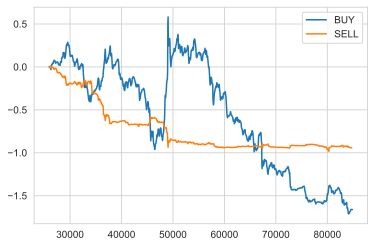

In [358]:
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)


# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

display(df)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='BUY')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='SELL')
plt.legend()
plt.show()


In [359]:
a = len(df[(df['y_pred_buy']>0) & (df['y_buy']>0)])
c = len(df[(df['y_pred_buy']>0) & (df['y_buy']<0)])
print(a, c)
print(f'buy target: {a/c}')

4685 5103
buy target: 0.9180873995688811


In [284]:
df[['size_ratio', 'y_buy', 'y_pred_buy']].head(30)

,size_ratio,y_buy,y_pred_buy
25943,0.259108,0.000947,-0.000128
25944,76.585924,0.000947,-0.000081
25945,2049.274959,0.000987,-0.001654
25946,75.052022,0.001109,0.000404
25947,99.149796,0.001109,0.000106
25948,35.275570,0.001140,0.000275
25949,12.001602,0.001190,0.000150
25950,18.242903,0.000000,-0.000053
25951,23.987375,0.000000,0.000012
25952,24.277298,0.000000,-0.000486
